In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ten_stocks = pd.read_csv('15min_df.csv')

In [3]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

## Ljung Box Test and Dicket Fuller Test of price

In [4]:
import statsmodels.api as sm

# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']  # p<0.05, Stationary

results = pd.DataFrame(columns=['stock', 'ljung_p', 'dickey-fuller_p'])
for stock_name in pool:
    result = {'stock': stock_name, 'ljung_p': sm.stats.acorr_ljungbox(ten_stocks[stock_name].dropna(), lags=[12], return_df=True)['lb_pvalue'].values[0]
             , 'dickey-fuller_p': test_stationarity(ten_stocks[stock_name].dropna())}
    results = results.append(result, ignore_index=True) 
results

,stock,ljung_p,dickey-fuller_p
0,600094.XSHG,0.0,0.399240
1,600160.XSHG,0.0,0.004108
2,600008.XSHG,0.0,0.058631
3,600903.XSHG,0.0,0.011145
4,000959.XSHE,0.0,0.401339
5,600970.XSHG,0.0,0.012710
6,002302.XSHE,0.0,0.189653
7,600823.XSHG,0.0,0.072151
8,002503.XSHE,0.0,0.434175
9,600664.XSHG,0.0,0.431124


## Price plot

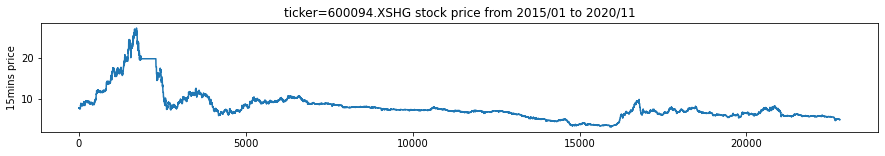

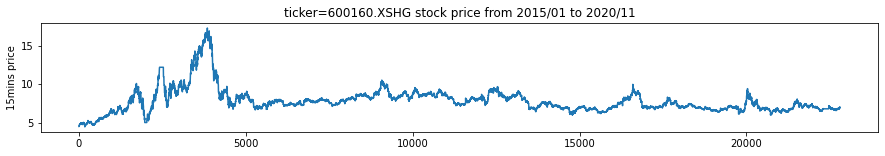

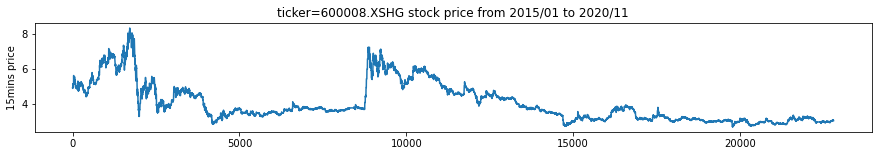

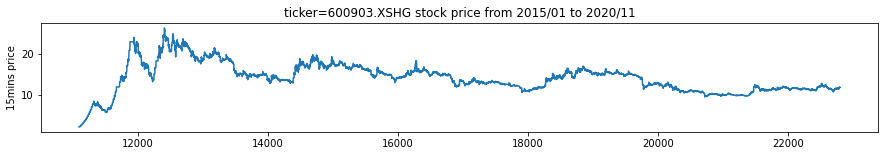

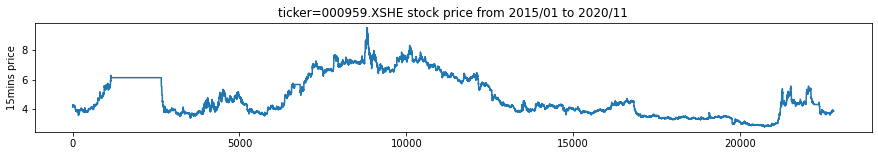

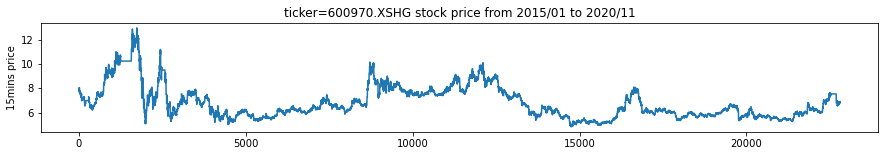

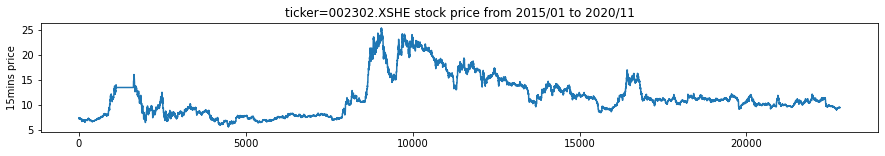

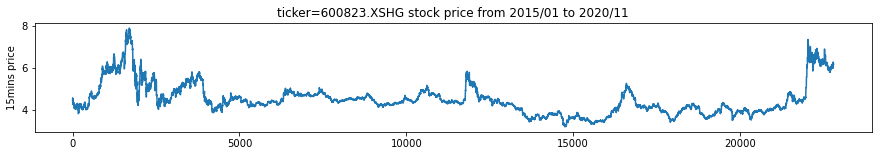

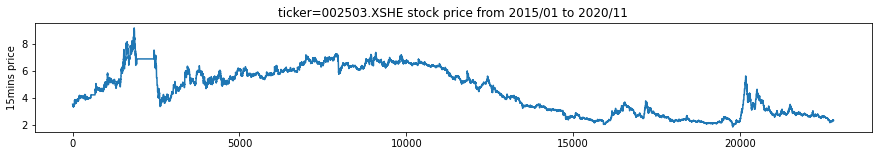

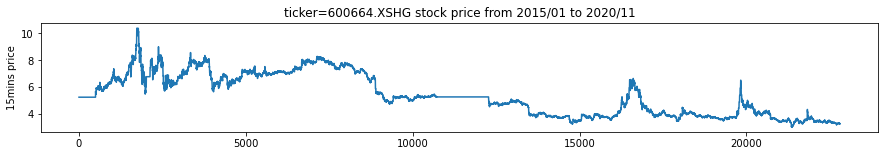

In [5]:
for stock_name in pool:
    ten_stocks[stock_name].dropna().plot(figsize=(15,2))
    plt.ylabel('15mins price')
    plt.title('ticker='+stock_name+' stock price from 2015/01 to 2020/11')
    plt.show()

## Log return plot + ACF/PACF

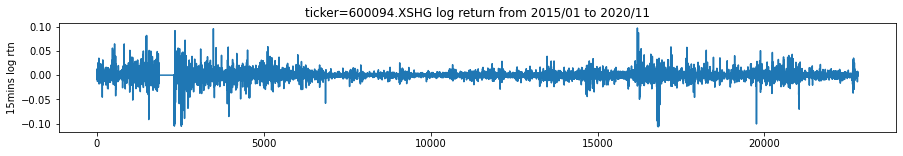

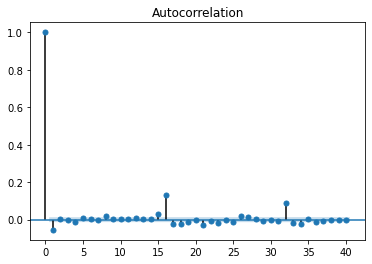

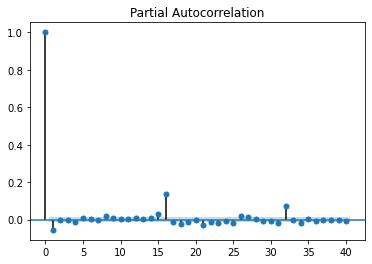

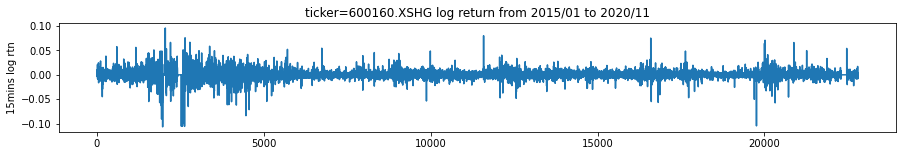

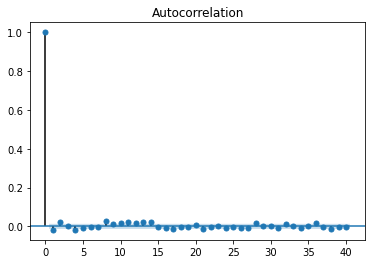

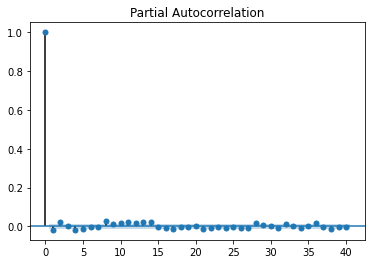

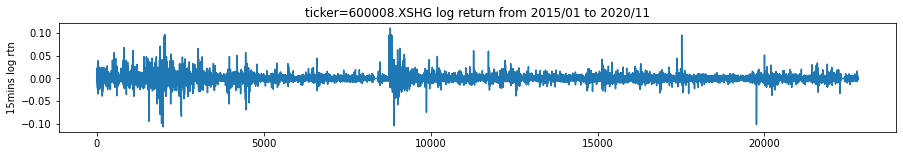

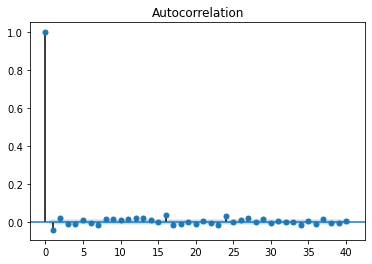

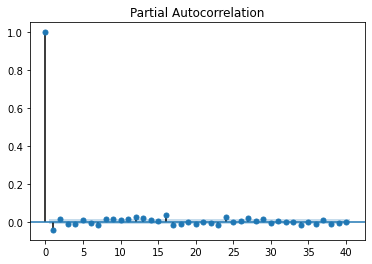

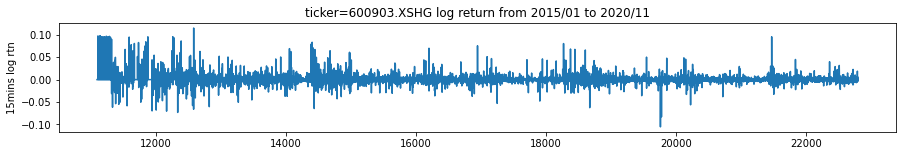

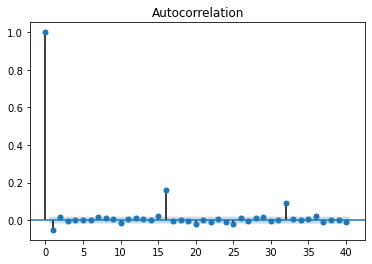

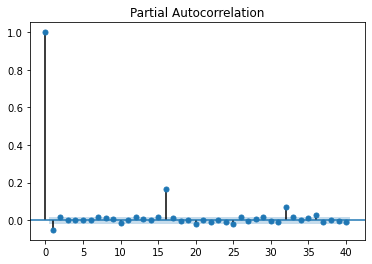

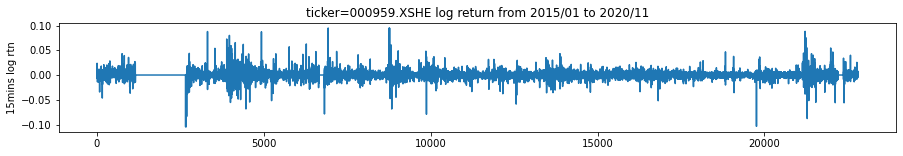

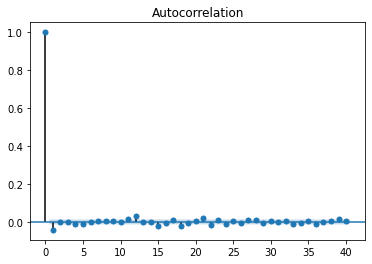

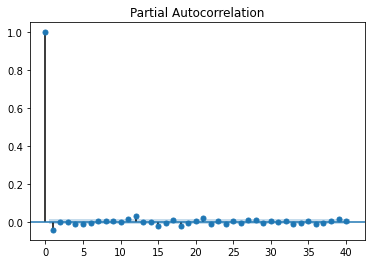

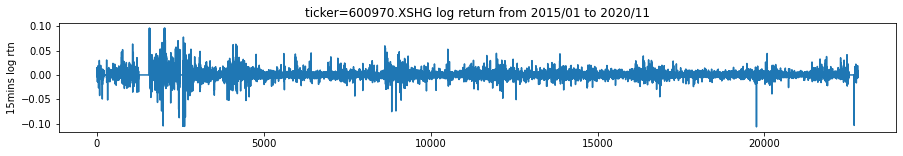

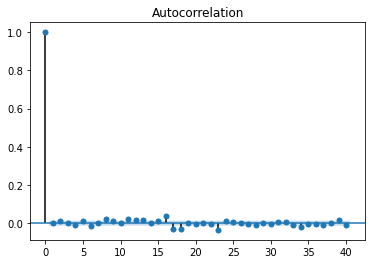

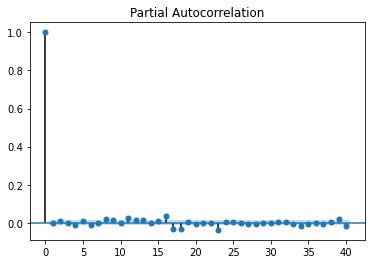

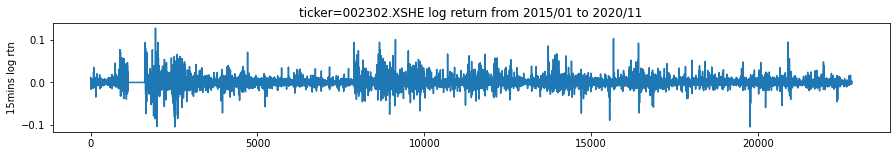

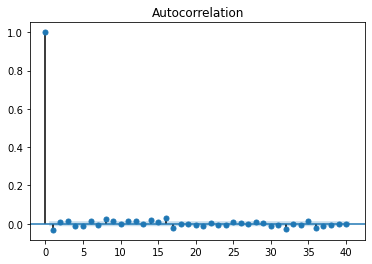

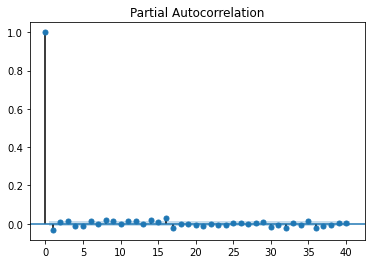

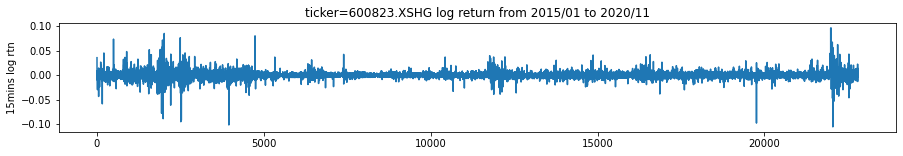

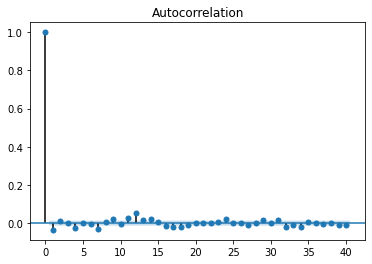

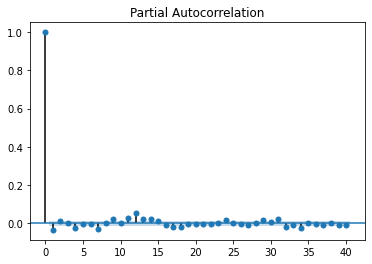

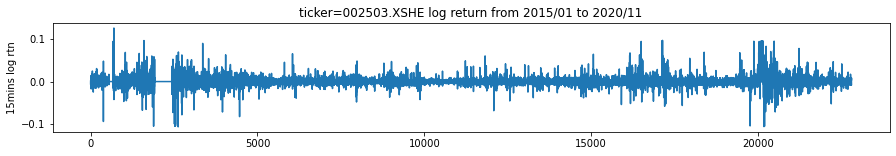

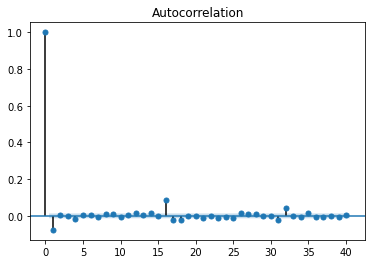

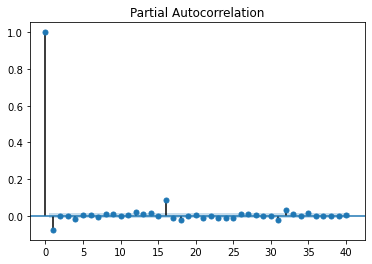

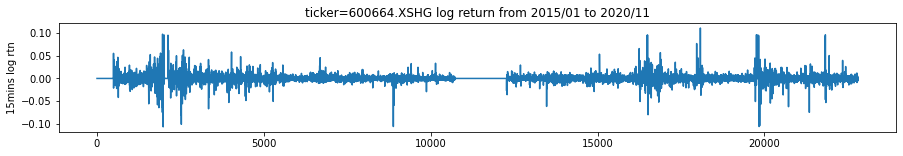

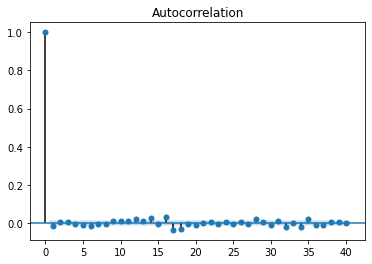

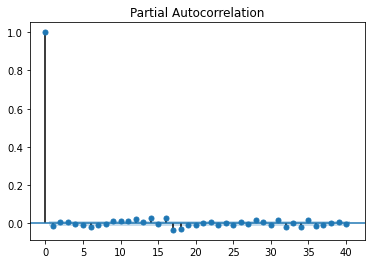

In [6]:
log_rtn_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_ten[stock_name] = log_rtn
    log_rtn.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn')
    plt.title('ticker='+stock_name+' log return from 2015/01 to 2020/11')
    plt.show()
    sm.graphics.tsa.plot_acf(log_rtn, lags=40) 
    plt.show()
    sm.graphics.tsa.plot_pacf(log_rtn, lags=40)
    plt.show()

## GARCH

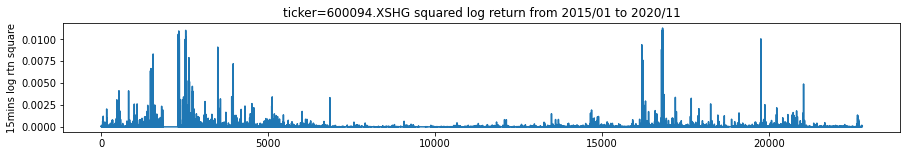

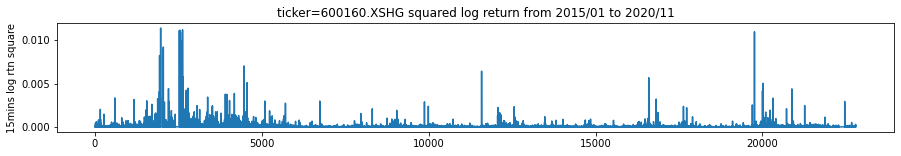

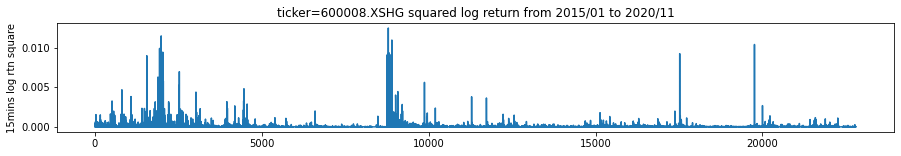

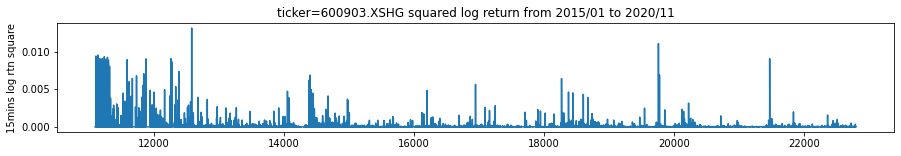

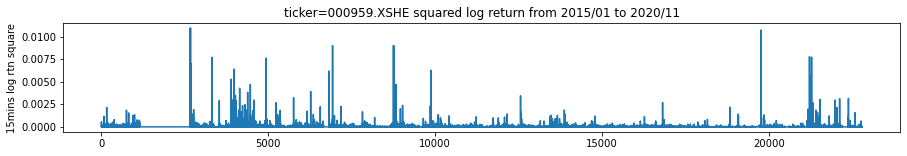

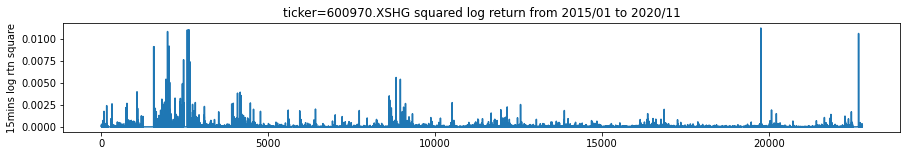

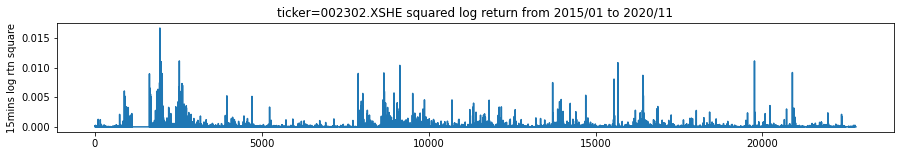

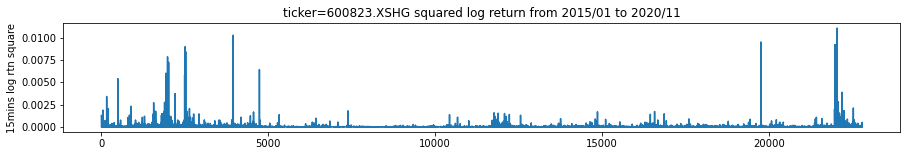

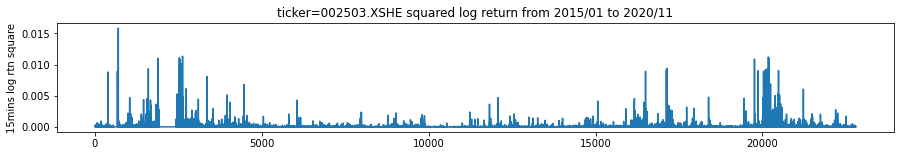

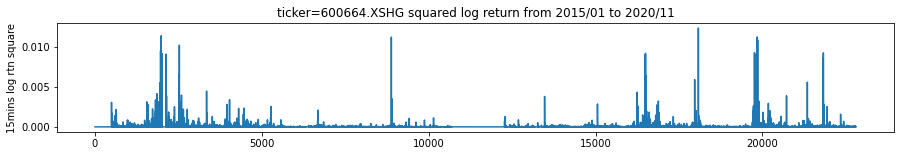

In [7]:
log_rtn_square_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_square = np.square(log_rtn - log_rtn.mean())
    log_rtn_square_ten[stock_name] = log_rtn_square
    log_rtn_square.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn square')
    plt.title('ticker='+stock_name+' squared log return from 2015/01 to 2020/11')
    plt.show()

In [8]:
import statsmodels.api as sm

results = pd.DataFrame(columns=['stock_name', 'ljung_p'])

for stock_name in pool:
    p_2 = sm.stats.acorr_ljungbox(log_rtn_square_ten[stock_name], lags=[40], return_df=True)['lb_pvalue'].values[0]
    result = {'stock_name': stock_name, 'ljung_p': p_2}
    results = results.append(result, ignore_index=True)
    
results[results['ljung_p']<0.05]

,stock_name,ljung_p
0,600094.XSHG,0.0
1,600160.XSHG,0.0
2,600008.XSHG,0.0
3,600903.XSHG,0.0
4,000959.XSHE,0.0
5,600970.XSHG,0.0
6,002302.XSHE,0.0
7,600823.XSHG,0.0
8,002503.XSHE,0.0
9,600664.XSHG,0.0


In [9]:
stocks_with_ARCH = results[results['ljung_p']<0.05]['stock_name'].values

In [ ]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_GARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        model = arch_model(log_rtn_ten[stock_name], mean='constant', p=p, q=q)
    
        res = model.fit(update_freq=0)
    
        ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
        aic = res.aic
        
        result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
        results = results.append(result, ignore_index=True)


for pq in combinations:
    train_GARCH(pq)



In [17]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,p,q,params,ljung_p,aic,stock_name
23,1,3,mu 0.000142 omega 0.000002 alph...,0.061339,-79899.276327,600903.XSHG


## EGARCH

In [ ]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_EGARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        try:
            model = arch_model(log_rtn_ten[stock_name], vol='EGARCH', mean='constant', p=p, q=q, dist='t')

            res = model.fit(update_freq=0)

            ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
            aic = res.aic

            result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
            results = results.append(result, ignore_index=True)
        except:
            continue


for pq in combinations:
    train_EGARCH(pq)



In [15]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,p,q,params,ljung_p,aic,stock_name
33,1,4,mu 2.448700e+01 omega -8.446424e...,1.000000,211976.436772,000959.XSHE
16,1,2,mu 7.467380 omega -1.540449 al...,1.000000,166077.794492,002302.XSHE
114,3,4,mu -1.215848e-11 omega -1.085251e...,0.699962,124827.706700,002503.XSHE
22,1,3,mu 4.311853e+01 omega -7.080916e...,1.000000,265149.677745,600008.XSHG
20,1,3,mu 1.183065e+01 omega -6.414901e...,1.000000,190643.713260,600094.XSHG
50,2,2,mu -22.467565 omega -0.59124...,1.000000,209904.847750,600160.XSHG
145,4,3,mu 5.858915e-09 omega -1.924777e...,1.000000,56833.730025,600664.XSHG
93,3,2,mu -22.276185 omega -1.015514 ...,1.000000,209573.862054,600823.XSHG
13,1,2,mu 21.756822 omega -0.118695 ...,1.000000,106216.205450,600903.XSHG
25,1,3,mu -12.928299 omega -15.167419 ...,1.000000,192867.287526,600970.XSHG
